In [1]:
from cued_sf2_lab.laplacian_pyramid import quantise
from cued_sf2_lab.familiarisation import load_mat_img, plot_image
import numpy as np
import IPython.display
import matplotlib.pyplot as plt
import inspect
import warnings
%matplotlib widget


# 10. Selection of preferred energy compaction options

The remainder of this project will concentrate on developing the rest of
an image compression system, based on a few of the filtering /
transformation schemes studied so far.

Since the subsequent processes are non-linear, we cannot expect to be able to
choose precisely the right front-end at this stage, so we adopt the pragmatic
approach of picking about three good candidates and trust that one of these
will lead to a near-optimum solution in the end. Remember that up to this point we have only been using entropy to give us an _estimate_ of the number of bits required, the accuracy of which is affected by subsequent stages.

At this stage it is worth trying your schemes with all three
test images, (`Lighthouse`, `Bridge`, and `Flamingo`). You will find `Bridge` more difficult to compress than the other two. You may also want to introduce other images of your own.

In [2]:
lighthouse, _ = load_mat_img(img='lighthouse.mat', img_info='X')
bridge, _ = load_mat_img(img='bridge.mat', img_info='X')
flamingo, _ = load_mat_img(img='flamingo.mat', img_info='X')


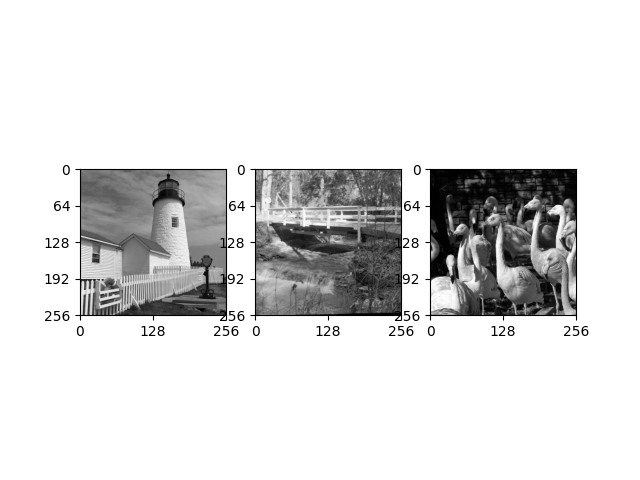

In [3]:
fig, axs = plt.subplots(1, 3)
plot_image(lighthouse, ax=axs[0])
plot_image(bridge, ax=axs[1])
plot_image(flamingo, ax=axs[2])


Write `.py` files to implement each of your
chosen schemes, so that you do not have to remember long sequences
of commands each time you run them. You can easily edit the M-files to introduce different options
later.  Using plenty of comments in these files will help when you want to change them.

In [4]:
from lp import *
from lbt import *
from dwt import *
from dct import *
from cued_sf2_lab.dct import regroup
from cued_sf2_lab.laplacian_pyramid import bpp
from cued_sf2_lab.laplacian_pyramid import quantise


# 11. Centre-clipped linear quantisers

The quantisers that you have used so far have all been uniform quantisers
(i.e.  all steps have been the same size).  However the probability
distributions of the intensities of the bandpass sub-images from the energy
compaction front-ends are usually highly peaked at zero.  The amount of data
compression depends heavily on the proportion of data samples which are
quantised to zero; if this approaches unity then high compression is
achieved.

Hence it is often found desirable to make the quantiser non-linear
so that more samples tend to be quantised to zero.  A simple way
to achieve this is to widen the step-size of the "zero" step.  In
a uniform quantiser, the "zero" step is normally centred on zero,
with rises to the next level at $\pm$ half of the step-size on
each side of zero. `quantise` allows a third argument `rise1` to be specified, which is
the point at which the first rise occurs on each side of the zero step.  A
value of `rise1` = `step/2` is the default, but `rise1` = $\left\{0.5, 1, 1.5\right\}\times$ `step` are worth investigating. To show what effect these have, try:

```python
x = np.arange(-100, 100+1)
y = quantise(x, 20, rise1)
fig, ax = plt.subplots()
ax.plot(x, y)
ax.grid()
```

In [5]:
# your code here
# step = 20
# rise1 = 1.5*step
# x = np.arange(-100, 100+1)
# y = quantise(x, 20, rise1)
# fig, ax = plt.subplots()
# ax.plot(x, y)
# ax.grid()


A wider zero step means that more samples will be coded as zero and so the
entropy of the data will be reduced.  The use of a wide zero step is
beneficial if it results in a better entropy vs. error tradeoff than a uniform
quantiser.

<div class="alert alert-block alert-danger">

For each of your preferred front-end
schemes, investigate the effects of varying the first rise of the
quantiser.  To do this, you could plot how the quantising error
varies as a function of the number of bits for a few different ratios of
`rise1` to step-size, and hence find the ratio which gives the
best compression for a given rms error. </div>

The entropy of the lighthouse is: 212781.64054358492
The entropy of the flamingo is: 222412.4152709274
The entropy of the bridge is: 221002.34556085148
Step size to rise ratio that gives minimum RMS for lighthouse under a dct of N=8 is: 0.30000000000000004
Step size to rise ratio that gives minimum RMS for flamingo under a dct of N=8 is: 0.30000000000000004
Step size to rise ratio that gives minimum RMS for bridge under a dct of N=8 is: 0.30000000000000004
Optimal compression ratio for lighthouse under a dct of N=8 is: 4.591172808609965
Optimal compression ratio for flamingo under a dct of N=8 is: 3.7889224059533855
Optimal compression ratio for bridge under a dct of N=8 is: 3.6130029030586077


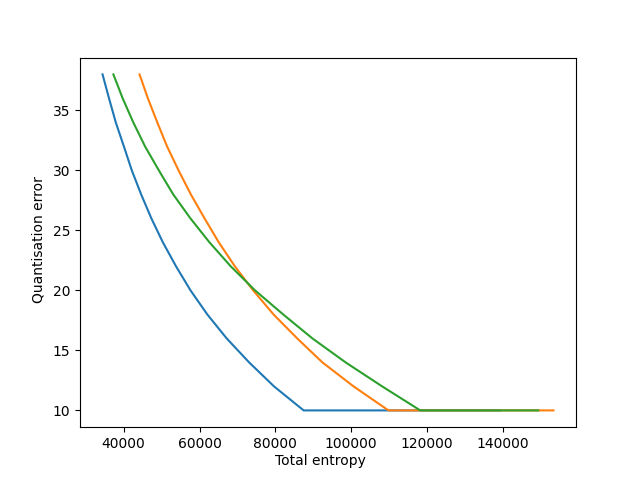

In [6]:
# You may wish to work in standalone python files (instead of notebooks) at this point!

lighthouse = lighthouse - 128.0
flamingo = flamingo - 128.0
bridge = bridge - 128.0

print("The entropy of the lighthouse is: " +
      str(entropy(quantise(lighthouse, 20))))
print("The entropy of the flamingo is: " +
      str(entropy(quantise(flamingo, 20))))
print("The entropy of the bridge is: " + str(entropy(quantise(bridge, 20))))

step = 20
factors = np.arange(0.1, 2, 0.1)


def dct_rise_error(image1, step, image2=None, image3=None):
    errors = []
    rms_error = []
    for i in factors:
        rise1 = step * i
        errors.append(abs(image1 - quantise(image1, step, rise1)).max())
        rms_error.append(dct_std(image1, step, rise1))

    if image2 is not None:
        errors2 = []
        rms_error2 = []
        for i in factors:
            rise2 = step * i
            errors2.append(abs(image2 - quantise(image2, step, rise2)).max())
            rms_error2.append(dct_std(image2, step, rise2))

    if image3 is not None:
        errors3 = []
        rms_error3 = []
        for i in factors:
            rise3 = step * i
            errors3.append(abs(image3 - quantise(image3, step, rise3)).max())
            rms_error3.append(dct_std(image3, step, rise3))

    return errors, errors2, errors3, rms_error, rms_error2, rms_error3


def dct_rise_entropy(image1, N, step, image2=None, image3=None):
    Y1 = dct_encode(image1)
    entropies = []
    for i in factors:
        Y_q = quantise(Y1, step, step * i)
        entropy_yl = dctbpp(regroup(Y_q,N), N)
        entropies.append(entropy_yl)

    if image2 is not None:
        Y2 = dct_encode(image2)
        entropies2 = []
        for i in factors:
            Y_q2 = quantise(Y2, step, step * i)
            entropy_yb = dctbpp(regroup(Y_q2,N), N)
            entropies2.append(entropy_yb)

    if image3 is not None:
        Y3 = dct_encode(image3)
        entropies3 = []
        for i in factors:
            Y_q3 = quantise(Y3, step, step * i)
            entropy_yf = dctbpp(regroup(Y_q3,N), N)
            entropies3.append(entropy_yf)

    return entropies, entropies2, entropies3


errors, errors2, errors3, std1, std2, std3 = dct_rise_error(lighthouse, 20, flamingo, bridge)
entropies, entropies2, entropies3 = dct_rise_entropy(lighthouse, 8, 20, flamingo, bridge)


print("Step size to rise ratio that gives minimum RMS for lighthouse under a dct of N=8 is: " + str(factors[np.argmin(std1)]))
print("Step size to rise ratio that gives minimum RMS for flamingo under a dct of N=8 is: " + str(factors[np.argmin(std2)]))
print("Step size to rise ratio that gives minimum RMS for bridge under a dct of N=8 is: " + str(factors[np.argmin(std3)]))


print("Optimal compression ratio for lighthouse under a dct of N=8 is: " + str(entropy(lighthouse) / entropies[np.argmin(std1)]))
print("Optimal compression ratio for flamingo under a dct of N=8 is: " + str(entropy(flamingo) / entropies2[np.argmin(std2)]))
print("Optimal compression ratio for bridge under a dct of N=8 is: " + str(entropy(bridge) / entropies3[np.argmin(std3)]))

fig, ax1 = plt.subplots(1)
ax1.plot(entropies, errors, label='Lighthouse')
ax1.plot(entropies2, errors2, label='Flamingo')
ax1.plot(entropies3, errors3, label='Bridge')

fig.text(0.5, 0.04, 'Total entropy', ha='center', va='center')
fig.text(0.06, 0.5, 'Quantisation error', ha='center', va='center', rotation='vertical')


plt.show()


Optimal compression ratio for lighthouse under a dwt of N=5 is: 10.906148621742558
Optimal compression ratio for flamingo under a dwt of N=5 is: 9.944472913956183
Optimal compression ratio for bridge under a dwt of N=5 is: 8.917589963341383
Step size to rise ratio that gives minimum RMS for lighthouse under a dct of N=8 is: 0.4
Step size to rise ratio that gives minimum RMS for flamingo under a dct of N=8 is: 0.4
Step size to rise ratio that gives minimum RMS for bridge under a dct of N=8 is: 0.4


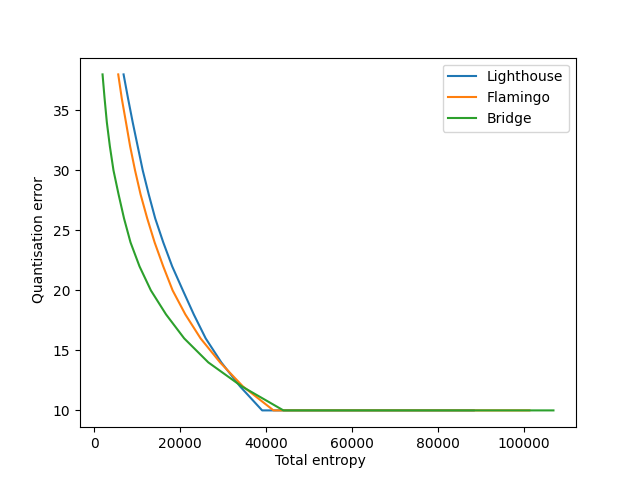

In [7]:

def dwt_rise_error(image1, step, image2=None, image3=None):
    errors = []
    rms_error1 = []
    for i in factors:
        rise1 = step * i
        errors.append(abs(image1 - quantise(image1, step, rise1)).max())
        rms_error1.append(dwt_std(image2, step, rise1, 5))

    if image2 is not None:
        errors2 = []
        rms_error2 = []
        for i in factors:
            rise2 = step * i
            errors2.append(abs(image2 - quantise(image2, step, rise2)).max())
            rms_error2.append(dwt_std(image2, step, rise2, 5))

    if image3 is not None:
        errors3 = []
        rms_error3 = []
        for i in factors:
            rise3 = step * i
            errors3.append(abs(image3 - quantise(image3, step, rise3)).max())
            rms_error3.append(dwt_std(image3, step, rise3, 5))

    return errors, errors2, errors3, rms_error1, rms_error2, rms_error3


def dwt_rise_entropy(image1, step, n, image2=None, image3=None):
    Y = nlevdwt(image1, n)
    entropies1 = []
    for i in factors:
        Yq, dwtent = quantdwt(Y, np.ones((3, n + 1)) * step, step * i)
        x = np.sum(dwtent)
        entropies1.append(x)

    if image2 is not None:
        Y2 = nlevdwt(image2, n)
        entropies2 = []
        for i in factors:
            Yq, dwtent = quantdwt(Y2, np.ones((3, n + 1)) * step, step * i)
            x = np.sum(dwtent)
            entropies2.append(x)

    if image3 is not None:
        Y3 = nlevdwt(image3, n)
        entropies3 = []
        for i in factors:
            Yq, dwtent = quantdwt(Y3, np.ones((3, n + 1)) * step, step * i)
            x = np.sum(dwtent)
            entropies3.append(x)

    return entropies1, entropies2, entropies3


errors11, errors21, errors31, std21, std22, std23 = dwt_rise_error(lighthouse, 20, flamingo, bridge)
entropiesdwt1, entropiesdwt2, entropiesdwt3 = dwt_rise_entropy(lighthouse, 20, 5, flamingo, bridge)

print("Optimal compression ratio for lighthouse under a dwt of N=5 is: " + str(entropy(lighthouse) /entropiesdwt1[np.argmin(std21)]))
print("Optimal compression ratio for flamingo under a dwt of N=5 is: " + str(entropy(flamingo) / entropiesdwt2[np.argmin(std22)]))
print("Optimal compression ratio for bridge under a dwt of N=5 is: " + str(entropy(bridge) / entropiesdwt3[np.argmin(std23)]))

print("Step size to rise ratio that gives minimum RMS for lighthouse under a dct of N=8 is: " + str(factors[np.argmin(std21)]))
print("Step size to rise ratio that gives minimum RMS for flamingo under a dct of N=8 is: " + str(factors[np.argmin(std22)]))
print("Step size to rise ratio that gives minimum RMS for bridge under a dct of N=8 is: " + str(factors[np.argmin(std23)]))

fig, ax2 = plt.subplots(1)
ax2.plot(entropiesdwt1, errors11, label='Lighthouse')
ax2.plot(entropiesdwt2, errors21, label='Flamingo')
ax2.plot(entropiesdwt3, errors31, label='Bridge')
ax2.legend()


fig.text(0.5, 0.04, 'Total entropy', ha='center', va='center')
fig.text(0.06, 0.5, 'Quantisation error', ha='center', va='center', rotation='vertical')

plt.show()


In [17]:
def lbt_rise_error(image1, step, s, N, image2=None, image3=None):
    errors = []
    rms_error1 = []
    for i in factors:
        rise1 = step * i
        print(lbt_std(image1, step, rise1, s, N))
        errors.append(abs(image1 - quantise(image1, step, rise1)).max())
        rms_error1.append(lbt_std(image1, step, rise1, s, N))

    if image2 is not None:
        errors2 = []
        rms_errors2 = []
        for i in factors:
            rise2 = step * i
            errors2.append(abs(image2 - quantise(image2, step, rise2)).max())
            rms_errors2.append(lbt_std(image2, step, rise2, s, N))

    if image3 is not None:
        errors3 = []
        rms_errors3 = []
        for i in factors:
            rise3 = step * i
            errors3.append(abs(image3 - quantise(image3, step, rise3)).max())
            rms_errors3.append(lbt_std(image3, step, rise3, s,N))

    return errors, errors2, errors3, rms_error1, rms_errors2, rms_errors3


def lbt_rise_entropy(image1, step, s, N, image2=None, image3=None):
    Y1 = lbt_encode(image1, s, N)
    entropies1 = []
    for i in factors:
        Y_q = quantise(Y1, step, step * i)
        Y_r = regroup(Y_q, N)
        bits = dctbpp(Y_r)
        entropies1.append(bits)

    if image2 is not None:
        Y2 = lbt_encode(image1, s, N)
        entropies2 = []
        for i in factors:
            Y_q = quantise(Y2, step, step * i)
            Y_r = regroup(Y_q, N)
            bits = dctbpp(Y_r)
            entropies1.append(bits)

    if image3 is not None:
        Y3 = lbt_encode(image1, s, N)
        entropies2 = []
        for i in factors:
            Y_q = quantise(Y3, step, step * i)
            Y_r = regroup(Y_q, N)
            bits = dctbpp(Y_r)
            entropies1.append(bits)

    return entropies1, entropies2, entropies3

errors31, errors32, errors33, std31, std32, std33 = lbt_rise_error(lighthouse, 20,1.4,8, flamingo, bridge)
entropiesdwt1, entropiesdwt2, entropiesdwt3 = lbt_rise_entropy(lighthouse, 20, 1.4,8, flamingo, bridge)

print("Optimal compression ratio for lighthouse under a dwt of N=5 is: " + str(entropy(lighthouse) /entropiesdwt1[np.argmin(std21)]))
print("Optimal compression ratio for flamingo under a dwt of N=5 is: " + str(entropy(flamingo) / entropiesdwt2[np.argmin(std22)]))
print("Optimal compression ratio for bridge under a dwt of N=5 is: " + str(entropy(bridge) / entropiesdwt3[np.argmin(std23)]))

print("Step size to rise ratio that gives minimum RMS for lighthouse under a dct of N=8 is: " + str(factors[np.argmin(std21)]))
print("Step size to rise ratio that gives minimum RMS for flamingo under a dct of N=8 is: " + str(factors[np.argmin(std22)]))
print("Step size to rise ratio that gives minimum RMS for bridge under a dct of N=8 is: " + str(factors[np.argmin(std23)]))

fig, ax2 = plt.subplots(1)
ax2.plot(entropiesdwt1, errors11, label='Lighthouse')
ax2.plot(entropiesdwt2, errors21, label='Flamingo')
ax2.plot(entropiesdwt3, errors31, label='Bridge')
ax2.legend()


fig.text(0.5, 0.04, 'Total entropy', ha='center', va='center')
fig.text(0.06, 0.5, 'Quantisation error', ha='center', va='center', rotation='vertical')

plt.show()

TypeError: unhashable type: 'numpy.ndarray'

Most current image compression standards use quantisers with a
double-width centre step (`rise1 = step`). Do not spend too much time
on this as the compression gains are likely to be quite small.

<div class="alert alert-block alert-danger">


Discuss whether your results indicate that `rise1 = step`
is a reasonable compromise if all quantisers are to be similar.
</div>

A final strategy which you can consider is to completely suppress some
sub-images or DCT coefficients.  This is equivalent to increasing `rise1`
to a very large value for these components.  In the sub-images / coefficients
which represent only the highest horizontal and vertical frequency components
combined, the effects of suppression can be almost unnoticable and yet
a useful saving in number of bits can be achieved.

<div class="alert alert-block alert-danger">

Investigate any additional gains which can be achieved with suppression
of some sub-images / coefficients.
</div>